# SpotiPy Weekly

By George Brown, Zachary Goldstein, and Zuhayer Quazi

### Introduction

Our overall goal with this project is to analyze a spotify user's playlists to predict which songs they would like and which they would not like. The steps for accomplishing this are:

1. Download the user's playlists, as well as an equal number of songs in genres which the user dislikes.
2. Create features from both numerical features of the song, such as tempo, and categorical features, such as key.
3. Create a model to predict whether or not a song is in the user's playlists.
4. Use this model to pick songs out of the top new releases that have a high probability of being in the user's playlists, and therefore a high probability of being liked by the user.

### Previous Related Work



1.   http://tamaszilagyi.com/blog/analyzing-my-spotify-listening-history/
2.   https://towardsdatascience.com/making-your-own-discover-weekly-f1ac7546fedb



## Installing/Importing Libraries

Installing Spotipy Library

In [0]:
# !pip install spotipy
# The rest of the libraries used are standard

In [0]:
# Data Collection - Spotify
import spotipy
import spotipy.util as util

# Data Cleaning / Processing / Analysis
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt

# Clustering
from sklearn.cluster import KMeans

# Splitting into Training and Testing Data
from sklearn import model_selection

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

## **Pulling User Data using Spotipy**
First, we need to pull all the songs/playlist data for a given user. We will do this using Spotipy. The user will insert his/her username (in my case, it is 'zquazi'), from which point they will be redirected to log in. Once the user is authenticated, we will receive a token and will then be able to access all user Spotify data. 

In [5]:
artists = [] #all artists
song_ids = [] #all song ids
song_names = [] #names of all songs
playlist_s = [] #names of playlists
all_songs = {} #dictionary of all playlists + songs in each playlist

def show_tracks(tracks, playlist_name):
    for i, item in enumerate(tracks['items']):
        track = item['track']
        #extract tracks from a given playlist --> if track is not NULL, extract data and add to lists
        if(track['id'] != None):
          artists.append(track['artists'][0]['name'])
          song_ids.append(track['id'])
          song_names.append(track['name'])
          playlist_s.append(playlist_name)
          all_songs[playlist_name].append(track['name'])


username = 'zquazi' #my spotify username

#get token from spotify + authenticate user
token = util.prompt_for_user_token(username,scope = 'user-library-read',client_id='91d0861f48494759abc3ff706433c107',client_secret='1a4622890abc418e817727a1b0266ebe',redirect_uri='https://example.com/callback')

if token:
    #iterate through user playlists and extract songs
    sp = spotipy.Spotify(auth=token)
    playlists = sp.user_playlists(username)
    for playlist in playlists['items']:
        if playlist['owner']['id'] == username:
            all_songs[playlist['name']] = []
            print(playlist['name'])
            print('  total tracks', playlist['tracks']['total'])
            results = sp.user_playlist(username, playlist['id'],
                fields="tracks,next")
            tracks = results['tracks']
            show_tracks(tracks, playlist['name'])
            while tracks['next']:
                tracks = sp.next(tracks)
                show_tracks(tracks, playlist['name'])
else:
    print("Can't get token for", username)
       

NameError: ignored

## Accessing Audio Features
Now, we have all user song/playlist data. The next step is to extract the audio features for each song within the user's library, which will allow us to predict a user's song preferences.

The features that we are able to extract are:


1.   Danceability (how suitable a song is for dancing)
2.   Energy (a measure of the intensity of the song)
3.   Key (the key of a song, e.g. "C#", "Bb", etc.)
4.   Loudness (average loudness in decibels)
5.   Mode (whether a song is major (1) or minor (0))
6.   Speechiness (the presence of spoken words in a song)
7.   Acousticness (a confidence measure from 0.0 to 1.0 of how likely a song is to be acoustic)
8.   Liveness (the probability that the song was recorded live)
9.   Tempo (how fast the song is, in beats per minute)
10.  Valence (how positive/negative a song is)
11.  Duration (in ms)
12.  Instrumentalness (predicts whether a song contains vocals or not; score from 0.0 to 1.0)
13.  Time Signature (estimated overall time signature - specifies how many beats are in each bar/measure)



In [5]:
chunks = [song_ids[x:x+50] for x in range(0, len(song_ids), 50)]
features = []
#get audio features from sp.audio_features for a subsection of our songs
for chunk in chunks:
  features += sp.audio_features(chunk)

#lists for each audio feature
danceability = []
energy = []
key = []
loudness = []
mode = []
speechiness = []
acousticness = []
liveness = []
tempo = []
valence = []
duration = []
instrumentalness = []
mode = []
time_signature = []

#add corresponding feature into correct list
for elem in features:
  danceability.append(elem['danceability'])
  energy.append(elem['energy'])
  key.append(elem['key'])
  loudness.append(elem['loudness'])
  mode.append(elem['mode'])
  speechiness.append(elem['speechiness'])
  acousticness.append(elem['acousticness'])
  liveness.append(elem['liveness'])
  tempo.append(elem['tempo'])
  valence.append(elem['valence'])
  duration.append(elem['duration_ms'])
  instrumentalness.append(elem['instrumentalness'])
  time_signature.append(elem['time_signature'])





TypeError: ignored

## Building Our DataFrame
Now that we have the audio features for all the songs within the user's library, we will convert our data into a DataFrame. 

In [0]:
#create dictionary of data to insert into our DataFrame.
d = {'song name': song_names, 'playlist':playlist_s, 'song id': song_ids,'duration':duration, 'instrumentalness':instrumentalness, 'mode':mode,'time_signature':time_signature, 'artist':artists, 'danceability': danceability, 'key':key, 'energy':energy, 'mode':mode, 'speechiness':speechiness, 'loudness':loudness, 'acousticness':acousticness, 'liveness':liveness, 'tempo':tempo, 'valence':valence}

#create DataFrame
df = pd.DataFrame(data=d)
df.head()

Index(['acousticness', 'artist', 'danceability', 'duration', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'playlist',
       'song id', 'song name', 'speechiness', 'tempo', 'time_signature',
       'valence'],
      dtype='object')
(3513, 17)


,acousticness,artist,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,playlist,song id,song name,speechiness,tempo,time_signature,valence
0,0.0599,Bon Jovi,0.522,250627,0.882,0.000210,0,0.3300,-3.216,1,hateful,3X7abqSXC4xrxuC1ykpWcY,Livin' On A Prayer,0.0359,122.541,4,0.815
1,0.0231,Guns N' Roses,0.443,274027,0.960,0.434000,8,0.3510,-8.070,1,hateful,0bVtevEgtDIeRjCJbK3Lmv,Welcome To The Jungle,0.0757,123.378,4,0.243
2,0.0372,Warrant,0.472,201027,0.946,0.000000,2,0.3520,-4.591,1,hateful,7LygtNjQ65PSdzVjUnHXQb,Cherry Pie,0.1450,177.489,4,0.486
3,0.0249,Aerosmith,0.629,211027,0.785,0.000009,5,0.0522,-10.761,1,hateful,2vX5WL7s6UdeQyweZEx7PP,Walk This Way,0.0471,108.531,4,0.869
4,0.0158,The Cranberries,0.309,306440,0.649,0.005950,7,0.3670,-8.994,1,hateful,6xy6jNeNTYwjnKTDzMyHw2,Zombie,0.0350,166.915,4,0.313


**Getting file from local environment**

Because the above data can only be retrieved with user credentials, we packaged it in a csv file that can be accessed locally.

In [15]:
df = pd.read_csv('skrt.csv',index_col=0)

FileNotFoundError: ignored

## Data Cleaning and Processing

In order to easily ensure model fairness, we limit the dataset to contain an equal number of songs in the user's playlists and not in the user's playlists. We also drop duplicates based on identical song features.

In [0]:
subset = list(df.columns)
subset.remove('playlist')
subset.remove('song id')
df = df.drop_duplicates(subset = subset)
df.head()

In [34]:
df['Good']=df['playlist'].apply(lambda s: 1 if s != 'hateful' else 0)
df = df.sort_values(by='Good')
df = df.head(1711*2)
df['Good'].value_counts()

1    1711
0    1711
Name: Good, dtype: int64

In [10]:
print(df.shape)
df.columns

(3500, 17)


Index(['acousticness', 'artist', 'danceability', 'duration', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'playlist',
       'song id', 'song name', 'speechiness', 'tempo', 'time_signature',
       'valence'],
      dtype='object')

## Exploration and Visualization

We explored various numerical features of the data to visualize possible 
differences between songs labeled 'Good' and 'Bad'.

### Tempo

In [1]:
plt.style.use("ggplot")  # Set Matplotlib style so plots look nice
dfPlot = df.copy() # Create copy of dataset which we can use for plotting
dfPlot['Good']=dfPlot['Good'].apply(lambda x: "Good" if x==1 else "Bad") # Change 0/1 to Bad/Good

NameError: ignored

In [16]:
dfPlot.boxplot(column='tempo',by='Good')
plt.ylabel("Tempo")
plt.xlabel("")
plt.title("Tempo of Bad vs. Good Songs")
plt.suptitle("") # removing default title
plt.show()

NameError: ignored

### Mode

In [0]:
dfPlot['mode'] = dfPlot['mode'].apply(lambda x: "Major" if x==1 else "Minor") # Convert 0,1 to Minor,Major

In [103]:
dfPlot['Goodness']=dfPlot['Good']
dfPlot.groupby(['mode','Goodness']).size().unstack() # Create frequency table grouped by Mode + Goodness

Goodness,Bad,Good
mode,,
Major,1028,1089
Minor,683,622


### Boxplots

In [0]:
# Returns a boxplot showing the relationship between a variable (var) and Goodness/Badness of songs in the pandas dataframe (df)
def boxplot(df,var):
  df.boxplot(column=var,by='Good')
  plt.ylabel(var)
  plt.xlabel("")
  plt.title(var.capitalize() +" of Bad vs. Good Songs")
  plt.suptitle("")
  return plt.show()

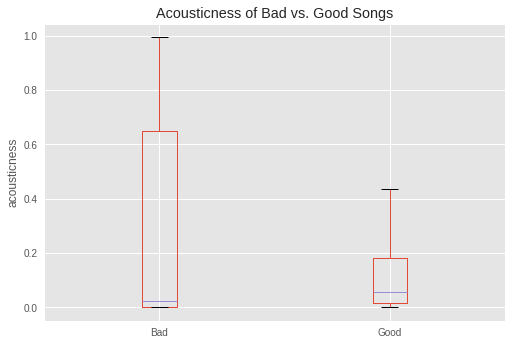

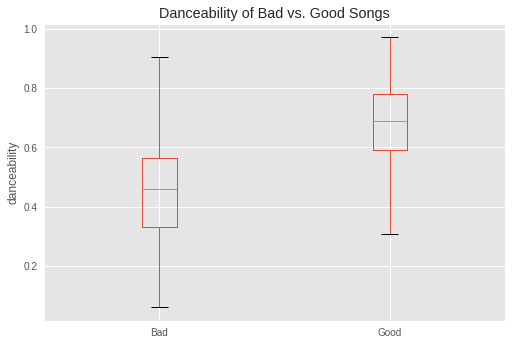

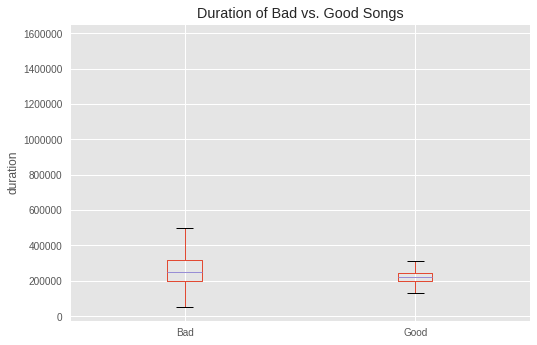

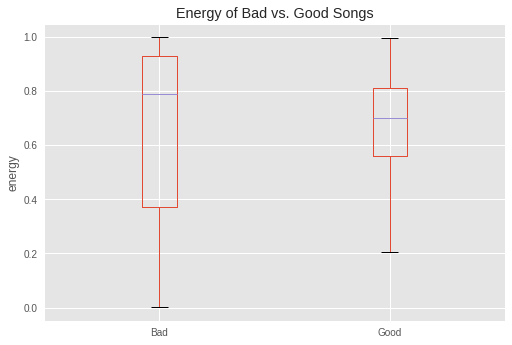

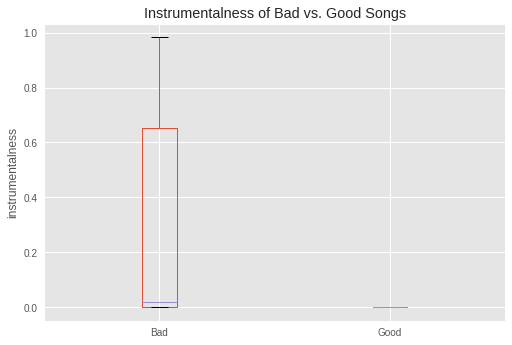

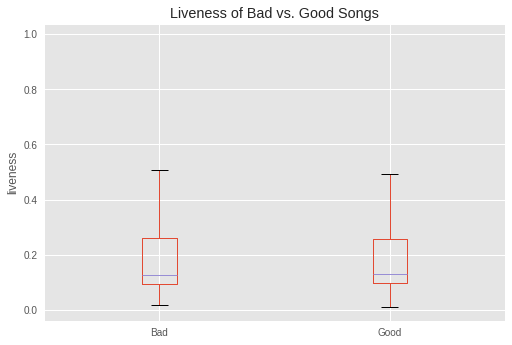

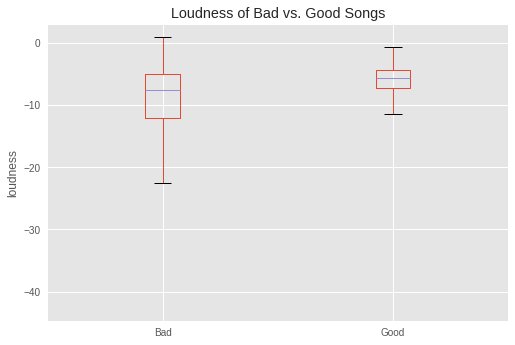

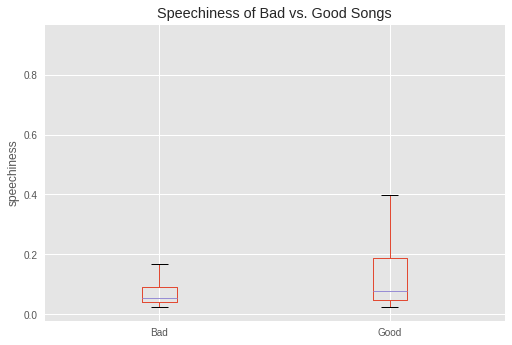

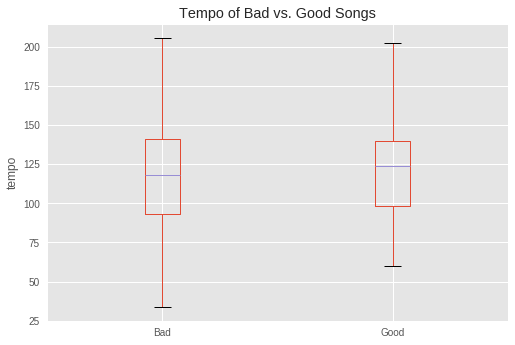

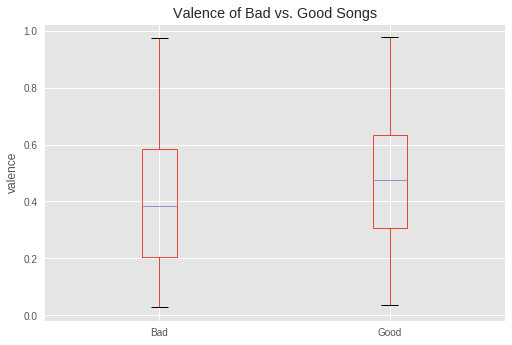

In [93]:
vars = ['acousticness','danceability','duration','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence']
for var in vars:
  boxplot(dfPlot,var)


## Clustering:

We chose to use K-means clustering to approximate the playlists and attempt to assign every song to a playlist. For this, we used all quantitative variables. We chose our initial k as the number of user playlists.







In [97]:
quantVariables = ['acousticness','danceability','energy','liveness','speechiness','tempo','valence','duration','instrumentalness','loudness']
X = df[quantVariables]
X.head()

,acousticness,danceability,energy,liveness,speechiness,tempo,valence,duration,instrumentalness,loudness
0,0.986000,0.382,0.158,0.1270,0.0466,46.950,0.3140,424243,0.823000,-12.962
1150,0.182000,0.466,0.942,0.1760,0.0554,90.006,0.3580,274667,0.000000,-7.345
1149,0.743000,0.285,0.297,0.1380,0.0339,103.653,0.1560,283529,0.000000,-9.259
1148,0.000062,0.519,0.905,0.0581,0.0592,134.029,0.4840,210259,0.655000,-4.632
1147,0.000459,0.584,0.759,0.1020,0.0397,114.998,0.0754,238932,0.000004,-6.718


### Normalizing Features

We converted features to their Z-Scores by subtracting the mean and dividing by the standard deviation of each feature

In [98]:
X = X.dropna()
Xnorm= X.copy()
for column in Xnorm.columns:
  colMean = Xnorm[column].mean()
  colSD = Xnorm[column].std()
  Xnorm[column]=(Xnorm[column]-colMean)/colSD
Xnorm.head()

,acousticness,danceability,energy,liveness,speechiness,tempo,valence,duration,instrumentalness,loudness
0,2.502967,-0.963017,-1.953968,-0.428996,-0.592234,-2.506740,-0.538594,1.432369,2.227664,-0.931195
1150,-0.090782,-0.528711,1.065853,-0.106658,-0.504345,-1.038958,-0.348860,0.179725,-0.515130,0.093761
1149,1.719035,-1.464537,-1.418566,-0.356635,-0.719075,-0.573731,-1.219911,0.253941,-0.515130,-0.255494
1148,-0.677723,-0.254684,0.923336,-0.882244,-0.466392,0.461789,0.194469,-0.359669,1.667774,0.588813
1147,-0.676443,0.081386,0.360972,-0.593455,-0.661148,-0.186979,-1.567469,-0.119543,-0.515117,0.208172


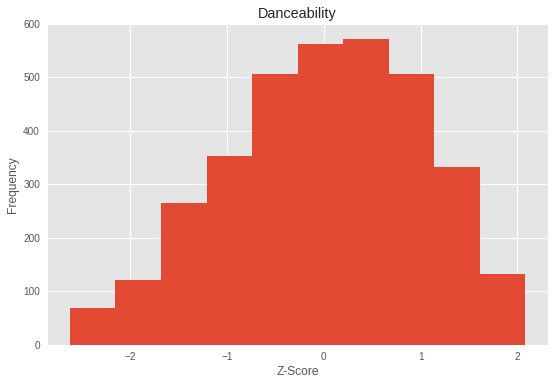

In [105]:
Xnorm['danceability'].plot(kind='hist')
plt.title("Danceability")
plt.xlabel("Z-Score")
plt.show()

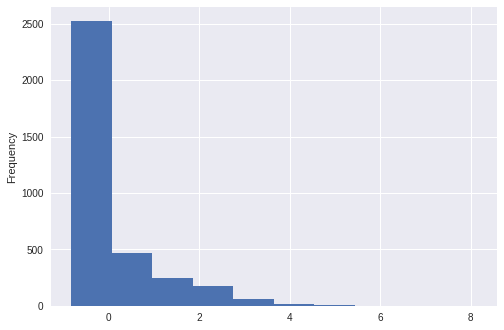

In [18]:
Xnorm['speechiness'].plot(kind='hist')

### Trying K-Means with different values of K

Because the benefit of additional k was less after k > 10, we chose 10 clusters for our final clustering model.

In [100]:
dictt2 = dict()
n = 16
for i in range(1,n):
  kmeans = KMeans(n_clusters = i).fit(Xnorm) # fit model to data with i clusters
  dictt2[i]=kmeans.inertia_ # squared error
  print(i,kmeans.inertia_)

1 34210.0
2 25288.571407205534
3 22177.703241186955
4 20148.324461160326
5 18310.823829519028
6 16904.753048534632
7 15951.902388912342
8 15223.064046955851
9 14514.761937634294
10 13897.325222746418
11 13304.372235484703
12 12909.45500035134
13 12550.191832394778
14 12205.361383981466
15 11894.653124951406


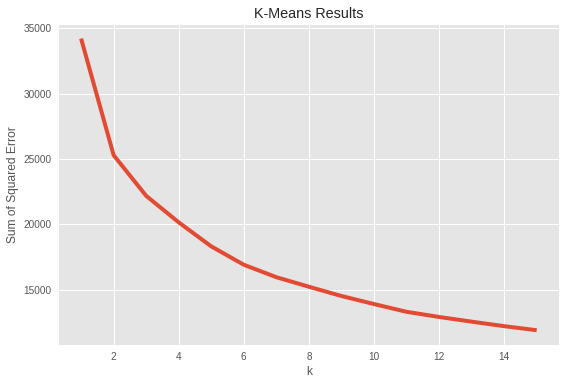

In [101]:
ser2 = pd.Series(dictt2)
ser2.plot(kind='line')
plt.ylabel("Sum of Squared Error")
plt.xlabel("k")
plt.title("K-Means Results")
plt.show()

In [21]:
means10 = KMeans(n_clusters = 10,random_state=0).fit(Xnorm)
means10.labels_

array([4, 5, 6, ..., 0, 1, 0], dtype=int32)

In [0]:
df2 = df.dropna()

### Compare clusters to playlists


Here, we tried to see if the k-means generated clusters were similar to the user's playlists. However, we found that only a few clusters made up most of the playlists, so there was not a strong similarity between the clusters and playlists.

In [0]:
df2 = df2.reset_index(drop=True)

In [27]:
for clusterLabel in range(10):
  clusterSongs = df2['song name'].values[means10.labels_ == clusterLabel] # Selects all song names corresponding to a certain cluster label
  clusterPlaylists = df2['playlist'].values[means10.labels_ == clusterLabel] # Selects all playlists corresponding to a certain cluster
  topPlaylist = pd.Series(clusterPlaylists).value_counts().head(1).index[0] # Selects the most common playlist for songs in the cluster
  playlist2 = pd.Series(clusterPlaylists).value_counts().head(2).index[1] # Selects the second most commmon playlist for songs in the cluster
  topPlaylistProp = pd.Series(clusterPlaylists).value_counts().head(1).values[0] / len(clusterPlaylists) # The proportion of songs in the cluster which are part of top playlist 
  playlistProp2 = pd.Series(clusterPlaylists).value_counts().head(2).values[1] / len(clusterPlaylists) # The proportion of songs in the cluster which are part of the 2nd top playlist
  
  if topPlaylist != "goodfeel":
      print(clusterLabel,topPlaylist,topPlaylistProp)
  else:
    print(clusterLabel,playlist2,playlistProp2)
  

0 hateful 0.3085399449035813
1 hateful 0.6829268292682927
2 LOL 0.15
3 hateful 0.9857142857142858


IndexError: ignored

In [28]:
df2['cluster']=pd.Series(means10.labels_)
for playlist in df2['playlist'].unique():
    playlistSongs = df2[df2.playlist==playlist]
    topCluster = playlistSongs['cluster'].value_counts().head(1).index[0] # Selects the most common cluster for songs in the playlist
    topClusterProp = len(playlistSongs[playlistSongs.cluster==topCluster]) / len(playlistSongs) # The proportion of songs in the playlist which are part of top cluster
    print(playlist,"\n \t top cluster: "+ str(topCluster),"\n \t cluster prop " + str(topClusterProp))
    

hateful 
 	 top cluster: 8 
 	 cluster prop 0.23787258912916423
boothy 
 	 top cluster: 7 
 	 cluster prop 0.38636363636363635
Practice 
 	 top cluster: 7 
 	 cluster prop 0.5454545454545454
enjoy 
 	 top cluster: 2 
 	 cluster prop 0.4186046511627907
Bangers 
 	 top cluster: 2 
 	 cluster prop 0.41333333333333333
Thoughts 
 	 top cluster: 7 
 	 cluster prop 0.42857142857142855
linear algebra 
 	 top cluster: 7 
 	 cluster prop 0.38235294117647056
LOL 
 	 top cluster: 7 
 	 cluster prop 0.3316062176165803
TB 
 	 top cluster: 0 
 	 cluster prop 0.4574898785425101
turnt 
 	 top cluster: 2 
 	 cluster prop 0.3488372093023256
goodfeel 
 	 top cluster: 0 
 	 cluster prop 0.3160377358490566
Slower 
 	 top cluster: 6 
 	 cluster prop 0.27586206896551724
Christmas Hype 
 	 top cluster: 6 
 	 cluster prop 0.352112676056338
GR8 
 	 top cluster: 7 
 	 cluster prop 0.3300970873786408
Dub 
 	 top cluster: 8 
 	 cluster prop 0.37662337662337664
Band Songs 
 	 top cluster: 0 
 	 cluster prop 0.5


In [29]:
df2['cluster'].value_counts()

0    726
8    538
7    492
1    492
2    360
5    219
9    208
4    206
6    189
3     70
Name: cluster, dtype: int64

## Classification

Because the k-means model was not sufficient, we opted to try a classification model where the user picks songs they don't like, and we try to classify whether a song would be liked or not. Again, we equalized the number of songs labeled 'Good' and 'Bad'. We also used additional categorical variables such as key and time signature.

In [33]:
df['Good']=df['playlist'].apply(lambda s: 1 if s != 'hateful' else 0)
df['Good'].value_counts()

1    1789
0    1711
Name: Good, dtype: int64

In [34]:
# Dropping duplicates based on song ID if any
df = df.drop_duplicates(subset=['song id'])
df['Good'].value_counts()

1    1789
0    1711
Name: Good, dtype: int64

In [35]:
# Equalize data to include equal number of good and bad songs

df = df.sort_values(by='Good')
df = df.head(1711*2)
df['Good'].value_counts()

1    1711
0    1711
Name: Good, dtype: int64

In [36]:
df = pd.get_dummies(df,columns=['key','time_signature']) # One-hot encoding of categorical variables 'key' and 'time_signature'
df.columns

Index(['acousticness', 'artist', 'danceability', 'duration', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'mode', 'playlist',
       'song id', 'song name', 'speechiness', 'tempo', 'valence', 'Good',
       'key_0', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7',
       'key_8', 'key_9', 'key_10', 'key_11', 'time_signature_0',
       'time_signature_1', 'time_signature_3', 'time_signature_4',
       'time_signature_5'],
      dtype='object')

In [37]:
X = df.drop(labels=['artist','playlist','Good','song id','song name'],axis=1) # Exclude certain columns from features
y = df['Good']
X.columns

Index(['acousticness', 'danceability', 'duration', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness',
       'tempo', 'valence', 'key_0', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'time_signature_0', 'time_signature_1', 'time_signature_3',
       'time_signature_4', 'time_signature_5'],
      dtype='object')

In [43]:
# train test split
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=.3,random_state=3)
X_train.head()

,acousticness,danceability,duration,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,...,key_7,key_8,key_9,key_10,key_11,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5
1089,0.021700,0.628,188480,0.8870,0.007090,0.1070,-5.224,1,0.0370,130.047,...,0,0,0,0,0,0,0,0,1,0
3006,0.136000,0.666,198227,0.6270,0.000000,0.1180,-4.922,1,0.1560,169.946,...,0,0,0,0,0,0,0,0,1,0
503,0.037000,0.561,265337,0.8380,0.000031,0.2840,-6.416,1,0.0358,122.901,...,0,0,0,0,0,0,0,0,1,0
639,0.975000,0.199,563533,0.0904,0.859000,0.0731,-26.877,1,0.0399,70.764,...,0,1,0,0,0,0,0,0,1,0
1645,0.000185,0.334,204360,0.9490,0.001020,0.1090,-6.451,0,0.0749,127.828,...,1,0,0,0,0,0,0,0,1,0


In [46]:
# Logistic Regression
log = LogisticRegression()
log.fit(X_train, y_train)
log.score(X_test,y_test)

0.6007789678675755

In [48]:
# Gradient Boosting Classifier
clf = GradientBoostingClassifier()
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.9045764362220059

## Evaluate Model

In [61]:
dfProbs.sort_values(by='Good Prob',ascending=False)[['song name','Good Prob']].tail(50)

,song name,Good Prob
71,Shadow City,0.945074
34,Bedtime Stories (feat. The Weeknd) - From SR3MM,0.942124
83,Stay With Me,0.940908
80,I'll Be There,0.937629
5,"Genius - with Sia, Diplo & Labrinth",0.936968
76,Conexão,0.931440
6,Bet Ain't Worth the Hand,0.930636
30,All To Myself,0.922974
78,Love Is Stronger Than Pride,0.920686
90,Still Feel Like Your Man,0.911769


In [0]:
# Songs with ratings of 93% good probability of higher
goodS = """
0	Up In My Cocina - From SR3MM	0.994279
8	T'd Up - From SR3MM	0.994097
30	Accelerate	0.992923
22	Cap (feat. Trouble) - From Jxmtro	0.992294
41	Lions	0.992204
23	Changed Up - From Jxmtro	0.989324
9	Touchscreen Navigation - From Swaecation	0.989267
1	CLOSE (feat. Travis Scott) - From SR3MM	0.989024
44	Mrs.	0.988655
32	The Way I Am	0.988585
5	"42" - From SR3MM	0.986100
3	Perplexing Pegasus - From SR3MM	0.985823
72	This Is How	0.985285
19	Players Club - From Jxmtro	0.984476
24	Keep God First - From Jxmtro	0.984321
50	KILL YOUR CONSCIENCE	0.984141
28	This Is America	0.984130
17	What's In Your Heart? - From Swaecation	0.984128
6	Powerglide (feat. Juicy J) - From SR3MM	0.983892
80	Jump (featuring Trippie Redd)	0.983699
4	Buckets (feat. Future) - From SR3MM	0.983603
33	Done For Me (feat. Kehlani)	0.982617
20	Anti-Social Smokers Club (feat. Zoë Kravitz) -...	0.982421
13	Guatemala - From Swaecation	0.981966
29	Watch (feat. Lil Uzi Vert & Kanye West)	0.978741
93	Move Them Britches - Heathens Remix	0.978614
65	Don't Give Up	0.977049
37	Bad Bad News	0.976897
15	Hurt To Look - From Swaecation	0.976836
38	Shy	0.973716
26	Growed Up - From Jxmtro	0.973215
40	Forgive You	0.972538
25	Juggling Biddies (feat. Riff 3x) - From Jxmtro	0.970556
91	Move Them Britches	0.970129
31	Hunger	0.967826
39	Beyond	0.964417
27	Youth (feat. Khalid)	0.963924
21	Chanel (feat. Swae Lee & Pharrell) - From Jxmtro	0.961873
7	Rock N Roll Hall Of Fame - From SR3MM	0.961690
18	Brxnks Truck - From Jxmtro	0.960156
12	Offshore (feat. Young Thug) - From Swaecation	0.958588
42	If It Feels Good (Then It Must Be)	0.953091
66	Everybody (feat. Sam King)	0.951527
11	Heat Of The Moment - From Swaecation	0.947481
70	Shadow City	0.945074
2	Bedtime Stories (feat. The Weeknd) - From SR3MM	0.942124
82	Stay With Me	0.940908
43	You Don't Know	0.938393
79	I'll Be There	0.937629
35	Genius - with Sia, Diplo & Labrinth	0.936968"""


### Songs with ratings of 46% good probability or lower
badS = """
53	DARKSIDE	0.453484
101	Please	0.444501
45	Georgia to Texas	0.439824
104	Tell Me Something	0.426231
67	Lemme See U	0.364039
103	Never Start	0.363133
56	GET UP	0.277780
52	MONSTERS	0.239409
58	THE HUMAN RADIO	0.236558
54	CREATURES	0.221383
49	ATTENTION ATTENTION	0.189917
96	Edge of Town	0.187822
73	I'll Wait (Vocal Mix) [feat. Shaylen]	0.175698
61	Baíle de Favela	0.154587
68	LSD	0.144370
62	Mystifying Oracle	0.139027
47	DEVIL	0.118551
59	BRILLIANT	0.103557
81	The One You Know	0.100097
63	Fake U Out	0.090315
48	BLACK SOUL	0.085934
51	PYRO	0.075718
55	EVOLVE	0.069970
64	Black Mamba	0.045118
46	THE ENTRANCE	0.023699

"""

In [0]:
goodSongs = goodS.splitlines()
goodList = []
for line in goodSongs:
  s = ''
  for c in line:
    if c.isalpha() or c == ' ':
      s = s+c
  goodList.append(s.strip())
badSongs = badS.splitlines()
badList = []
for line in badSongs:
  s = ''
  for c in line:
    if c.isalpha() or c == ' ':
      s = s+c
  badList.append(s.strip())

#### A Pandas Series containing songs and the model's rating

In [0]:
dictt = dict()
for song in goodList+badList:
  if song in goodList:
      dictt[song]="Good"
  else:
    dictt[song]="Bad"
ser = pd.Series(dictt)

## Testing Model on New Releases

To evaluate the model, we used songs from Spotify's "New Releases" playlists. We chose songs from the top 50 albums, and recommended those that had a probability greater than 97.5% of being liked by the user. We created a new playlist for the user containing these songs.

In [9]:
sp = spotipy.Spotify(auth=token)
playlists = sp.new_releases(limit=50)


albums = []
for album in playlists['albums']['items']:
  albums.append((sp.album(album['id'])))
track_ids = [item['id'] for album in albums for item in album['tracks']['items']]
artists1 = [item['artists'][0]['name'] for album in albums for item in album['tracks']['items']]
song_name1 = [item['name'] for album in albums for item in album['tracks']['items']]


features = [sp.audio_features(track_id)[0] for track_id in track_ids]

danceability1 = []
energy1 = []
key1 = []
loudness1 = []
mode1 = []
speechiness1 = []
acousticness1 = []
liveness1 = []
tempo1 = []
valence1 = []
duration1 = []
instrumentalness1 = []
mode1 = []
time_signature1 = []

for i, elem in enumerate(features):
  if(elem==None):
    del song_name1[i]
    del track_ids[i]
    del artists1[i]
  else:
    danceability1.append(elem['danceability'])
    energy1.append(elem['energy'])
    key1.append(elem['key'])
    loudness1.append(elem['loudness'])
    mode1.append(elem['mode'])
    speechiness1.append(elem['speechiness'])
    acousticness1.append(elem['acousticness'])
    liveness1.append(elem['liveness'])
    tempo1.append(elem['tempo'])
    valence1.append(elem['valence'])
    duration1.append(elem['duration_ms'])
    instrumentalness1.append(elem['instrumentalness'])
    time_signature1.append(elem['time_signature'])


d1 = {'song name' : song_name1, 'artists': artists1, 'song id': track_ids,'duration':duration1, 'instrumentalness':instrumentalness1, 'mode':mode1,'time_signature':time_signature1, 'danceability': danceability1, 'key':key1, 'energy':energy1, 'mode':mode1, 'speechiness':speechiness1, 'loudness':loudness1, 'acousticness':acousticness1, 'liveness':liveness1, 'tempo':tempo1, 'valence':valence1}
df_new = pd.DataFrame(data=d1)
print(df_new.columns)
print(df_new.shape)
df_new.head()

NameError: ignored

In [121]:
X_train.columns

Index(['acousticness', 'danceability', 'duration', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness',
       'tempo', 'valence', 'key_0', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'time_signature_0', 'time_signature_1', 'time_signature_3',
       'time_signature_4', 'time_signature_5'],
      dtype='object')

In [0]:
dfProbs = df_new.copy()

In [0]:
# Data processing

if 'key' in df_new.columns: df_new = pd.get_dummies(df_new,columns=['key','time_signature'])
if 'song id' in df_new.columns: df_new = df_new.drop(labels=['song id','song name', 'artists'],axis=1)
df_new['time_signature_0'] = 0
df_new['time_signature_1'] = 0
df_new['time_signature_5'] = 0

probs = clf.predict_proba(df_new)

dfProbs['Bad Prob']=pd.Series(clf.predict_proba(df_new)[:,0])
dfProbs['Good Prob']=pd.Series(clf.predict_proba(df_new)[:,1])



In [130]:
dfNew = dfProbs.sort_values(by='Good Prob',ascending=False)[['song name','artists','song id','Good Prob']]
dfNew = dfNew[dfNew['Good Prob'] > 0.975]
dfNew.head()

,song name,artists,song id,Good Prob
200,Frostbite,Preme,3XmKQDhplvk0wtPMuHOTHL,0.996205
192,Tonka,Desiigner,544FLIfmISCEEvPaU0Jn8w,0.996092
137,Cocaine,"Royce Da 5'9""",3qglYeMgK0rWFD2gcSojUw,0.995211
210,Loaded,Preme,4aR1EuT9zTZLIo2RnkhFpf,0.994814
199,No Defeat,Preme,2pCD1kCkSXHfM1rTzsIKgd,0.994318


In [69]:
ser[:10]

                                              Good
ATTENTION ATTENTION                            Bad
Accelerate                                    Good
AntiSocial Smokers Club feat Zoë Kravitz      Good
BLACK SOUL                                     Bad
BRILLIANT                                      Bad
Bad Bad News                                  Good
Baíle de Favela                                Bad
Bedtime Stories feat The Weeknd  From SRMM    Good
Beyond                                        Good
dtype: object

#### New songs used for user testing

In [0]:
zSongs = ['ATTENTION ATTENTION',
 'BLACK SOUL',
 'Bad Bad News',
 'Baíle de Favela',
 'Black Mamba',
 'Brxnks Truck  From Jxmtro',
 'Buckets feat Future  From SRMM',
 'CLOSE feat Travis Scott  From SRMM',
 'CREATURES',
 'Cap feat Trouble  From Jxmtro',
 'Chanel feat Swae Lee  Pharrell  From Jxmtro',
 'Changed Up  From Jxmtro',
 'DARKSIDE',
 'DEVIL',
 'Done For Me feat Kehlani',
 'Edge of Town',
 'Fake U Out',
 'GET UP',
 'Genius  with Sia Diplo  Labrinth',
 'Georgia to Texas',
 'Growed Up  From Jxmtro',
 'Guatemala  From Swaecation',
 'Heat Of The Moment  From Swaecation',
 'Hurt To Look  From Swaecation',
 'If It Feels Good Then It Must Be',
 'Ill Wait Vocal Mix feat Shaylen',
 'Jump featuring Trippie Redd',
 'KILL YOUR CONSCIENCE',
 'LSD',
 'Lemme See U',
 'MONSTERS',
 'Move Them Britches  Heathens Remix',
 'PYRO',
 'Perplexing Pegasus  From SRMM',
 'Please',
 'Rock N Roll Hall Of Fame  From SRMM',
 'Shy',
 'Stay With Me',
 'THE HUMAN RADIO',
 'Td Up  From SRMM',
 'Tell Me Something',
 'The One You Know',
 'This Is America',
 'This Is How',
 'Touchscreen Navigation  From Swaecation',
 'Watch feat Lil Uzi Vert  Kanye West',
 'Whats In Your Heart  From Swaecation',
 'You Dont Know',
 'Youth feat Khalid']

#### Predictions that the model made about the new songs (0 = Bad, 1 = Good)

In [71]:
predictions = []
for song in zSongs:
  if dictt[song] == "Good":
    predictions.append(1)
  else:
    predictions.append(0)
predictions[:10]

[0, 0, 1, 0, 0, 1, 1, 1, 0, 1]

#### User ratings of the new songs (0 = Bad, 1 = Good)

In [13]:
answers = [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]
zGood = answers.count(1)
zBad = answers.count(0)
zGood,zBad # The user rated 17 songas as good, and 32 as bad

(17, 32)

#### Model Accuracy

In [73]:
correct = 0
zGoodCorrect = 0
zBadCorrect = 0
for i in range(len(predictions)):
  if answers[i] == predictions[i]: # If the model is correct
    correct += 1
    if answers[i]==1: # If the user rates the song as good
      zGoodCorrect += 1
    else: # If the user rates the song as bad
      zBadCorrect += 1
print("Accuracy:",correct/len(predictions))
print("Accuracy Among Z Says Good",zGoodCorrect/zGood)
print("Accuracy Among Z Says Bad",zBadCorrect/zBad)

Accuracy: 0.7142857142857143
Accuracy Among Z Says Good 0.9411764705882353
Accuracy Among Z Says Bad 0.59375


##  Create New Playlist for User based on Predicted Top Songs

Spotify only allows adding up to 100 songs at a time, so we pick the top 100 songs from the list of songs that were chosen.

In [131]:
username = 'zquazi'
tokenNew = util.prompt_for_user_token(username,scope = 'playlist-modify-public',client_id='91d0861f48494759abc3ff706433c107',client_secret='1a4622890abc418e817727a1b0266ebe',redirect_uri='https://example.com/callback')

if tokenNew:
    sp = spotipy.Spotify(auth=tokenNew)
    new = sp.user_playlist_create(username, name = "New Songs for You")
songs_to_add = list(dfNew['song id'].values)
sp.user_playlist_add_tracks(username, new['id'], songs_to_add[:100])
    

TypeError: ignored

## Areas for Further Investigation

- We classified songs as either "Good" or "Bad", but we could also build a regression model to predict a quantitatie measure of a song's "Goodness"
- For example, we could try to predict how many times a song has been listened to (a proxy measure of how much a user likes a song)
- If we were able to obtain many users' spotify data, we could use collaborative filtering to recommend songs based on what similar users listen to